## warm up: sweep of expectation values across the phase diagram of the honeycomb Kitaev model

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

In [2]:
Xop=sp.sparse.csr_array([[0.,1.],[1.,0.]]) # Pauli X
Yop=sp.sparse.csr_array([[0,-1j],[1j,0.]])
Zop=sp.sparse.csr_array([[1.,0.],[0.,-1]])

In [3]:
def operator(op,idx,N):
  """
  Produce an operator that has single-qubit operator op acting
  on qubit with index idx, and the rest is identity. N is the total number of qubits.
  idx count starts at 0 and runs up to N-1.

  Example: Z_3
  >> operator(Zop,3,10)

  Example: X_0 X_2
  >>  operator(Xop,0,10) @ operator(Xop,2,10)
  """
  return sp.sparse.kron( sp.sparse.identity(2**idx), sp.sparse.kron(op, sp.sparse.identity(2**(N-idx-1))) )

def expectation(psi,op):
  """
  Calculate the expectation value of observable operator op with respect to state psi.
  This takes the real part automatically, assuming op is Hermitean !
  """

  return np.real( np.sum( np.conj(psi) * (op @ psi) ) )

def empty_matrix(n_dim):
  """
  Return the empty sparse matrix for a system of Hilbert space dimension n_dim.
  """
  return sp.sparse.csr_matrix((n_dim, n_dim), dtype='complex')

def produce_XYZ(N):
  """
  Return X,Y,Z = a list of all Pauli X operators, all Pauli Y, all Pauli Z,
  for given qubit number N
  """
  return ( [operator(Xop,idx,N) for idx in range(N)] ,
            [operator(Yop,idx,N) for idx in range(N)] ,
            [operator(Zop,idx,N) for idx in range(N)] )

def ground_state(H):
  """
  Return ground state of H, using sparse Lanczos.
  Returns eigenvalue, eigenvector
  """
  evals,evecs=sp.sparse.linalg.eigsh(H, k=1, which='SA')
  return evals[0], evecs[:,0]

def ground_state_fast(H, prev):
  """
  Return ground state of H, using sparse Lanczos.
  Returns eigenvalue, eigenvector
  """
  evals,evecs=sp.sparse.linalg.eigsh(H, k=1, which='SA', v0=prev)
  return evals[0], evecs[:,0]

def index_2d(jx,jy,Nx):
  return jx + jy * Nx

In [4]:
# generate all the single-qubit operators:
# Nx, Ny both have to be even (otherwise PBC does not work)
Nx = 8
Ny = 2
N = Nx * Ny # qubit number
X,Y,Z = produce_XYZ(N)
twist = 0

In [5]:
H_theta_term_x = 0 * X[0]
H_theta_term_y = 0 * X[0]
H_theta_term_z = 0 * X[0]
H_theta_term_magnetic = 0 * X[0]

magn_field = 0.00
theta_z = 1

for jx in range(0,Nx):
  for jy in range(0,Ny):
    if ((jx+jy) % 2) == 0:
        H_theta_term_x += X[index_2d(jx,jy,Nx)] @ X[index_2d((jx+1)%Nx,jy,Nx)]
        H_theta_term_z += Z[index_2d(jx,jy,Nx)] @ Z[index_2d((jx+twist)%Nx,(jy-1)%Ny,Nx)]
    else:
       H_theta_term_y += Y[index_2d(jx,jy,Nx)] @ Y[index_2d((jx+1)%Nx,jy,Nx)]
    ## magnetic field in [1,1,1] direction
    H_theta_term_magnetic += X[index_2d(jx,jy,Nx)] + Y[index_2d(jx,jy,Nx)] + Z[index_2d(jx,jy,Nx)]

H_theta_terms = [H_theta_term_x, H_theta_term_y]
H_const = theta_z * H_theta_term_z + magn_field * H_theta_term_magnetic

#H_sens_coupl = X[0] @ X[-2] + Z[0] @ Z[-1]

In [69]:
H_theta_term_x = 0 * X[0]
H_theta_term_y = 0 * X[0]
H_theta_term_z = 0 * X[0]
H_theta_term_magnetic = 0 * X[0]

magn_field = 0.00
theta_z = 1

for jx in range(0,Nx):
  for jy in range(0,Ny):
    if ((jx+jy) % 2) == 0:
        H_theta_term_x += X[index_2d(jx,jy,Nx)] @ X[index_2d((jx+1)%Nx,jy,Nx)]
        H_theta_term_z += Z[index_2d(jx,jy,Nx)] @ Z[index_2d((jx+twist)%Nx,(jy-1)%Ny,Nx)]
    else:
       H_theta_term_y += Y[index_2d(jx,jy,Nx)] @ Y[index_2d((jx+1)%Nx,jy,Nx)]
    ## magnetic field in [1,1,1] direction
    H_theta_term_magnetic += X[index_2d(jx,jy,Nx)] + Y[index_2d(jx,jy,Nx)] + Z[index_2d(jx,jy,Nx)]

H_theta_terms = [H_theta_term_x, H_theta_term_y, H_theta_term_z]
H_const = magn_field * H_theta_term_magnetic

#H_sens_coupl = X[0] @ X[-2] + Z[0] @ Z[-1]

In [70]:
def HamiltonianPhase(theta, H_theta_terms, H_out, out_coupl):
  """
  Construct a QEP Hamiltonian from the given components.

  H0 - untrainable terms in Hamiltonian

  H0_terms - terms for the untrainable part of the Hamiltonian
  theta_0 - parameters that define the phase diagram, untrainable

  theta - a vector (list or array) of trainable parameters
  H_theta_terms - a list of corresponding terms in the Hamiltonian

  Returns the Hamiltonian H as a sum of all these terms.
  """

  H = sp.sparse.csr_matrix((2**N, 2**N))

  ## trained part of Hamiltonian
  for jj in range(0,len(theta)):
    H += theta[jj] * H_theta_terms[jj]
  
  ## output part of Hamiltonian
  for jj in range(0,len(out_coupl)):
    H += out_coupl[jj] * H_out[jj]
  
  ## fixed constant term
  H += H_const

  return H

In [ ]:
def phase_diagram_2D_sweep(op, resolution):
    ## sweeps Jx and Jy and calculates Jz, calculates the ground state for each set of hopping parameters, and computes the expectation value of op
    ## resolution: step size
    tmp = np.array([])
    theta_sweep = np.array([0,0,0])
    for Jx in np.arange(0,1+resolution,resolution):
        for Jy in np.arange(0,1-Jx+resolution,resolution):
            Jz = 1 - Jx - Jy
            theta_sweep = np.array([Jx,Jy,Jz])
            _, eigVect = ground_state(HamiltonianPhase(theta_sweep, H_theta_terms, [op], [0.0]))
            tmp = np.append(tmp, [Jx, Jy, Jz, expectation(eigVect,op)])
    return tmp

In [ ]:
## sweeps Jx and Jy and calculates Jz, calculates the ground state for each set of hopping parameters, and computes the expectation value of Z[0] @ Z[index_2d(0,1,Nx)]
phase_diag_slice = phase_diagram_2D_sweep(Z[0] @ Z[index_2d(0,1,Nx)], .05)

In [87]:
list_len = int(len(phase_diag_slice)/4)

In [125]:
phase_diag_slice = np.reshape(phase_diag_slice,(list_len,4))

In [126]:
def diag_map(Jx,Jy,Jz):
    return [Jy+Jz/2, Jz/2 * np.sqrt(3)]

In [127]:
phase_diag_slice_remap = np.array([])
for jj in range(0,len(phase_diag_slice)):
    tmp = diag_map(phase_diag_slice[jj,0],phase_diag_slice[jj,1],phase_diag_slice[jj,2])
    phase_diag_slice_remap = np.append(phase_diag_slice_remap, [tmp[0],tmp[1],phase_diag_slice[jj,3]])
phase_diag_slice_remap = np.reshape(phase_diag_slice_remap, (list_len,3))

(-0.02, 0.89)

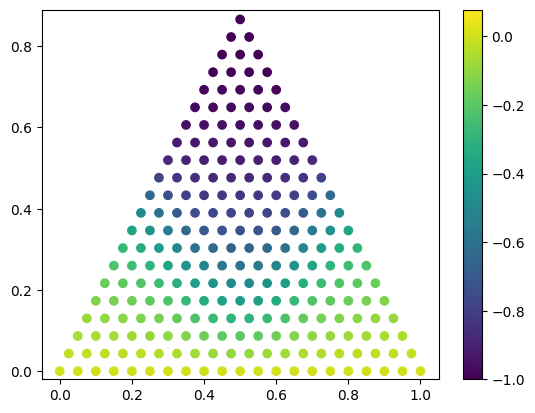

In [128]:
plt.scatter(phase_diag_slice_remap[:,0],phase_diag_slice_remap[:,1],c=phase_diag_slice_remap[:,2])
plt.colorbar()
plt.ylim([-.02,.89])

## setting up the phase sensor

In [ ]:
import os
cwd = os.getcwd()
os.chdir("/.") # <-- replace with relevant file directory

In [ ]:
import qep ## should be in directory selected above
import numpy as np
import time

In [20]:
M=10000 # make shot noise small
finite_nudging=0.05
learning_rate=0.01
num_batches=500
batch_size=6
test_step=1
seed=2
coupling_bound = 0.3

In [ ]:
symm_nudging=True

n_test_samples=200

# set up phase sensor (Hamiltonian terms etc)
# generate all the single-qubit operators:
# Nx, Ny both have to be even (otherwise PBC does not work)
Nx = 8
Ny = 2
twist = 0 # twist in boundary conditions, i.e. offset when connecting the last with the 1st unit cell
N_sys=16
N_sens=2

In [22]:
phase_sensor = qep.prepare_Kitaev_phase_sensor(Nx,Ny,twist,N_sens)

generate test set

In [ ]:
## random samples like the ones used later on in a batch for the training
x_test_samples,y_test_samples=qep.sample_batch_Kitaev_phase_sensor(1000)

In [ ]:
list_len = len(x_test_samples)
scatter_map = np.array([])
for jj in range(0,len(x_test_samples)):
    tmp = qep.diag_map(x_test_samples[jj,0],x_test_samples[jj,1],x_test_samples[jj,2])
    scatter_map = np.append(scatter_map, [tmp[0],tmp[1]])
scatter_map = np.reshape(scatter_map, (list_len,2))

fixed set of points spread across the phase diagramm that sample the same number of points in each phase (test set)

In [ ]:
## test set
test_list = np.array([## middle
                      #[1/3,1/3,1/3],
                      [.4,.4,.2],
                      [.2,.4,.4],
                      [.4,.2,.4],
                      [.3,.3,.4],
                      [.4,.3,.3],
                      [.3,.4,.3],
                      [.375,.375,.25],
                      [.25,.375,.375],
                      [.375,.25,.375],
                      ## top
                      #[1/6,1/6,2/3],
                      [.1,.1,.8],
                      [.1,.3,.6],
                      [.3,.1,.6],
                      ## left
                      #[2/3,1/6,1/6],
                      [2/3+(1/6-.1),1/6-(1/6-.1),.1],
                      [2/3-(1/6-.1)-.066,1/6+(1/6-.1)+.066,.1],
                      [2/3-(.3-1/6)/2,1/6-(.3-1/6)/2,.3],
                      ## right
                      #[1/6,2/3,1/6],
                      [1/6-(1/6-.1)-.066,2/3+(1/6-.1)+.066,.1],
                      [1/6+(1/6-.1),2/3-(1/6-.1),.1],
                      [1/6-(.3-1/6)/2,2/3-(.3-1/6)/2,.3]
                      ])

In [260]:
x_test_samples = test_list
y_test_samples = np.array([[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],
                           [1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0],[1,0]
                           ])

In [261]:
list_len = len(test_list)
test_scatter_map = np.array([])
for jj in range(0,len(test_list)):
    tmp = qep.diag_map(test_list[jj,0],test_list[jj,1],test_list[jj,2])
    test_scatter_map = np.append(test_scatter_map, [tmp[0],tmp[1]])
test_scatter_map = np.reshape(test_scatter_map, (list_len,2))

visualisation of a typical training set (coloured points) and the test set (black points)

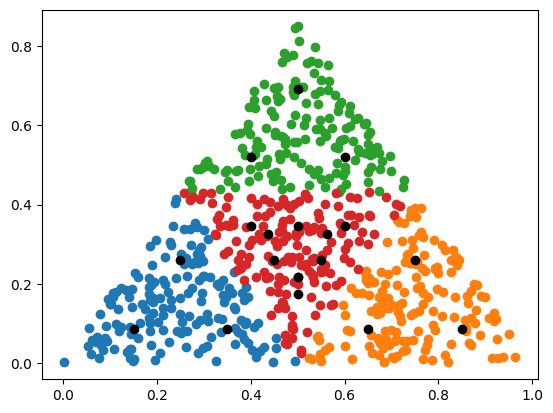

In [ ]:
## sxample for sampled points in Abelian (green, blue, organge) and non-Abelian phase
from matplotlib import pyplot as plt
plt.scatter(scatter_map[::6,0],scatter_map[::6,1])
plt.scatter(scatter_map[1::6,0],scatter_map[1::6,1])
plt.scatter(scatter_map[2::6,0],scatter_map[2::6,1])
plt.scatter(scatter_map[3::6,0],scatter_map[3::6,1])
plt.scatter(test_scatter_map[:,0],test_scatter_map[:,1],c='k')

# training

gradients are averaged over the batch according to the optimiser (here: a combination of adam for the initial stage of the training and adamx for the later stages of the training to avoid large fluctuations)

In [383]:
test_step=10
num_batches=400
learning_rate=0.01
test_step = 1

phase_sensor = qep.initialize_phase_sensor_parameters(phase_sensor,qep.optax.adamax(learning_rate),do_overwrite=False)

phase_sensor,training_history=qep.train_phase_sensor(phase_sensor,
    qep.sample_batch_Kitaev_phase_sensor,
    qep.cost_function_mse,qep.grad_cost_function_mse,
        learning_rate,batch_size,num_batches,
    test_step=test_step,test_samples=(x_test_samples,y_test_samples),
                        nonsparse=False,
                                    finite_nudging=finite_nudging,
                                    symmetric_nudging=symm_nudging,
                                    shot_noise=M,
                                    alternative_accuracies=True,
                                    coupling_bound = None)

Acc: 94.44444444444444 %: 100%|██████████| 400/400 [20:04:43<00:00, 180.71s/it]    


In [384]:
np.savez(f"results_2_ZZcoupling_adamax_400epochs.npz",
             sys_sens_couplings=phase_sensor['sys_sens_couplings'],
             sens_couplings=phase_sensor['sens_couplings'],
             accuracy=training_history['accuracy'],
             cost=training_history['cost'],
             training_cost=training_history['training_cost'],
             product_accuracy=training_history['product_accuracy'],
             single_shot_accuracy=training_history['single_shot_accuracy'],
             max_choice_accuracy=training_history['max_choice_accuracy'],
             theta=training_history['theta'])

In [390]:
np.savez(f"training_history_results_2_ZZcoupling_adamax_400epochs.npz",
             training_history)

In [ ]:
## continue training

test_step=10
num_batches=200
learning_rate=0.01
test_step = 1

#phase_sensor = qep.initialize_phase_sensor_parameters(phase_sensor,qep.optax.adamax(learning_rate),do_overwrite=False)

phase_sensor,training_history=qep.train_phase_sensor(phase_sensor,
    qep.sample_batch_Kitaev_phase_sensor,
    qep.cost_function_mse,qep.grad_cost_function_mse,
        learning_rate,batch_size,num_batches,
    test_step=test_step,test_samples=(x_test_samples,y_test_samples),
                        nonsparse=False,
                                    finite_nudging=finite_nudging,
                                    symmetric_nudging=symm_nudging,
                                    shot_noise=M,
                                    alternative_accuracies=True,
                                    coupling_bound = None)

Acc: 94.44444444444444 %: 100%|██████████| 200/200 [18:11:54<00:00, 327.57s/it]    


In [397]:
np.savez(f"results_2_ZZcoupling_adamax_400epochs_further200epochs.npz",
             sys_sens_couplings=phase_sensor['sys_sens_couplings'],
             sens_couplings=phase_sensor['sens_couplings'],
             accuracy=training_history['accuracy'],
             cost=training_history['cost'],
             training_cost=training_history['training_cost'],
             product_accuracy=training_history['product_accuracy'],
             single_shot_accuracy=training_history['single_shot_accuracy'],
             max_choice_accuracy=training_history['max_choice_accuracy'],
             theta=training_history['theta'])

In [399]:
np.savez(f"training_history_results_2_ZZcoupling_adamax_400epochs_further200epochs.npz",
             training_history)

In [ ]:
## continue training

test_step=10
num_batches=200
learning_rate=0.01
test_step = 1

#phase_sensor = qep.initialize_phase_sensor_parameters(phase_sensor,qep.optax.adamax(learning_rate),do_overwrite=False)

phase_sensor,training_history=qep.train_phase_sensor(phase_sensor,
    qep.sample_batch_Kitaev_phase_sensor,
    qep.cost_function_mse,qep.grad_cost_function_mse,
        learning_rate,batch_size,num_batches,
    test_step=test_step,test_samples=(x_test_samples,y_test_samples),
                        nonsparse=False,
                                    finite_nudging=finite_nudging,
                                    symmetric_nudging=symm_nudging,
                                    shot_noise=M,
                                    alternative_accuracies=True,
                                    coupling_bound = None)

Acc: 94.44444444444444 %: 100%|██████████| 200/200 [8:27:09<00:00, 152.15s/it]  


In [406]:
np.savez(f"results_2_ZZcoupling_adamax_400epochs_further200epochs_2.npz",
             sys_sens_couplings=phase_sensor['sys_sens_couplings'],
             sens_couplings=phase_sensor['sens_couplings'],
             accuracy=training_history['accuracy'],
             cost=training_history['cost'],
             training_cost=training_history['training_cost'],
             product_accuracy=training_history['product_accuracy'],
             single_shot_accuracy=training_history['single_shot_accuracy'],
             max_choice_accuracy=training_history['max_choice_accuracy'],
             theta=training_history['theta'])

In [407]:
np.savez(f"training_history_results_2_ZZcoupling_adamax_400epochs_further200epochs_2.npz",
             training_history)

In [408]:
phase_sensor['opt_state']

(ScaleByAdamState(count=Array(800, dtype=int32), mu=Array([ 0.22132185, -0.08977135,  0.04569792, -0.00686803, -0.09818655,
        -0.02893429, -0.03517729, -0.01248169,  0.00579006, -0.02673997,
        -0.04600096, -0.02934002, -0.22984737,  0.06132625, -0.04718986,
         0.03979833,  0.0720774 ,  0.04682526, -0.18077722,  0.01628869,
         0.61034703,  0.6538058 ,  0.02503079,  0.23279655,  0.23005292,
         0.06943951,  0.16432506, -0.07234547,  0.06110942, -0.06100295,
         0.07477924, -0.11903601,  0.0293325 ], dtype=float32), nu=Array([1.6599483 , 0.5962117 , 1.4025036 , 1.9190011 , 0.446976  ,
        0.7675935 , 0.5090962 , 0.30488485, 1.0485458 , 0.77540165,
        0.27327564, 0.39939964, 2.2782528 , 0.6221224 , 0.37196663,
        0.567946  , 0.7480017 , 0.36994576, 1.2970631 , 0.23745465,
        5.4556937 , 5.9567623 , 0.4333058 , 2.011912  , 2.4609468 ,
        0.7229546 , 1.5339344 , 0.8632216 , 0.96470404, 0.6438021 ,
        0.5003554 , 1.0086277 , 0.219

In [398]:
results_adamax_400 = np.load("results_2_ZZcoupling_adamax_400epochs.npz")

In [423]:
results_adamax_400_2 = np.load("results_2_ZZcoupling_adamax_400epochs_further200epochs.npz")

In [444]:
np.savez('training_cost_total.npz', np.concatenate((results_adamax_400['training_cost'],results_adamax_400_2['training_cost'],training_history['training_cost'])))
np.savez('max_choice_accuracy_total.npz', np.concatenate((results_adamax_400['max_choice_accuracy'],results_adamax_400_2['max_choice_accuracy'],training_history['max_choice_accuracy'])))
np.savez('single_shot_accuracy_total.npz', np.concatenate((results_adamax_400['single_shot_accuracy'],results_adamax_400_2['single_shot_accuracy'],training_history['single_shot_accuracy'])))

# visualisation of the training progress

the training cost is plotted for the training set at each stage of the training

the max choice accuracy and single-shot accuracy are shown for the test set

Text(0.5, 0, 'epochs')

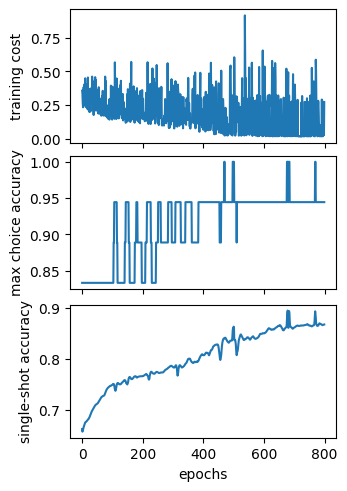

In [439]:
fig, axs = plt.subplots(3, 1, layout='constrained', sharex=True)

fig.set_figwidth(10)

aspect_ratio=.5

axs[0].set_box_aspect(aspect_ratio)
axs[1].set_box_aspect(aspect_ratio)
axs[2].set_box_aspect(aspect_ratio)

axs[0].plot(np.concatenate((results_adamax_400['training_cost'],results_adamax_400_2['training_cost'],training_history['training_cost'])))
axs[1].plot(np.concatenate((results_adamax_400['max_choice_accuracy'],results_adamax_400_2['max_choice_accuracy'],training_history['max_choice_accuracy'])))
axs[2].plot(np.concatenate((results_adamax_400['single_shot_accuracy'],results_adamax_400_2['single_shot_accuracy'],training_history['single_shot_accuracy'])))

axs[0].set_ylabel('training cost')
axs[1].set_ylabel('max choice accuracy')
axs[2].set_ylabel('single-shot accuracy')
axs[2].set_xlabel('epochs')

In [445]:
np.argmax(training_history['single_shot_accuracy'])

78

In [451]:
training_history['single_shot_accuracy'][78]

0.8941286662943608

In [452]:
training_history['max_choice_accuracy'][78]

1.0

In [448]:
phase_sensor_2 = phase_sensor

In [453]:
phase_sensor_2['theta'] = training_history['theta'][78]

Text(0.5, 0, 'epochs')

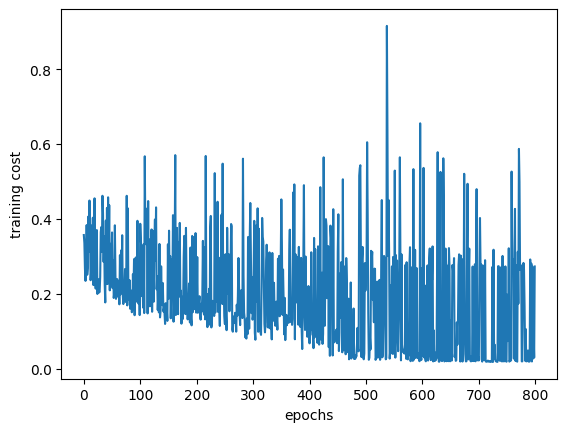

In [443]:
plt.plot(np.concatenate((results_adamax_400['training_cost'],results_adamax_400_2['training_cost'],training_history['training_cost'])))
plt.ylabel('training cost')
plt.xlabel('epochs')

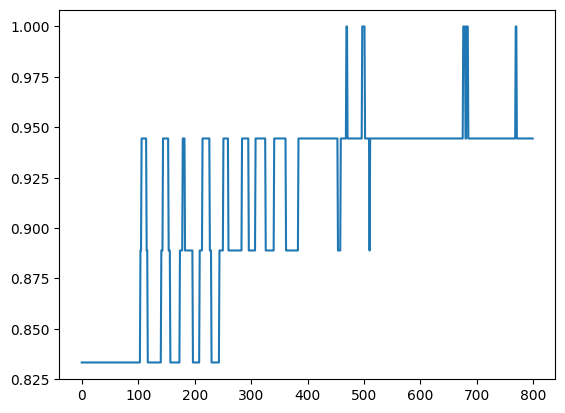

In [425]:
plt.plot(np.concatenate((results_adamax_400['max_choice_accuracy'],results_adamax_400_2['max_choice_accuracy'],training_history['max_choice_accuracy'])))

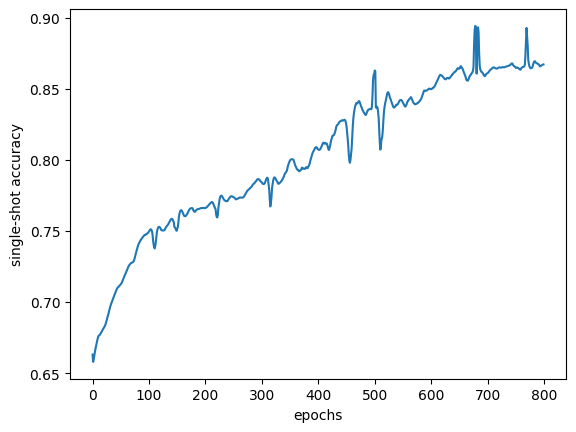

In [567]:
plt.plot(np.concatenate((results_adamax_400['single_shot_accuracy'],results_adamax_400_2['single_shot_accuracy'],training_history['single_shot_accuracy'])))
plt.ylabel('single-shot accuracy')
plt.xlabel('epochs')

plt.savefig('single_shot_accuracy_epochs.pdf')

In [573]:
training_history['max_choice_accuracy'][78]

1.0

In [574]:
training_history['single_shot_accuracy'][78]

0.8941286662943608

In [292]:
results500['max_choice_accuracy'][9]

0.9444444444444444

In [293]:
results500['theta'][90]

array([ 0.88115865, -0.17166501, -0.30206203, -1.608788  ,  0.1416153 ,
        0.01596566,  1.2023259 ,  0.7823847 , -0.6574642 , -0.40832746,
       -0.28168324,  0.7658125 , -1.025748  ,  1.0665838 ,  0.50587016,
       -0.01127989, -1.0462229 ,  0.983536  , -1.6718382 ,  0.45943365,
       -0.03229805, -0.45751292,  0.7274038 ,  0.64153844, -0.549959  ,
        0.73939985,  0.8022572 , -0.21276955, -0.7349207 ,  2.058331  ,
       -3.2649643 , -0.5539384 , -0.10431643], dtype=float32)

# accuracy of the trained sensor across the phase diagram

In [299]:
H,E,psi,y_pred = qep.evaluate_phase_sensor(phase_sensor,x_test_samples[0],results500['theta'][90])

In [311]:
value_single_shot_accuracy_mean = 0
correct_max_choice_mean = 0
value_single_shot_accuracy_list = np.array([])
correct_max_choice_list = np.array([])
for jj in range(len(x_test_samples)):
    H,E,psi,y_pred = qep.evaluate_phase_sensor(phase_sensor,x_test_samples[jj],results500['theta'][90])
    value_single_shot_accuracy = np.prod(y_test_samples[jj]*y_pred + (1-y_test_samples[jj]))
    value_single_shot_accuracy_mean += np.prod(y_test_samples[jj]*y_pred + (1-y_test_samples[jj]))
    value_single_shot_accuracy_list = np.append(value_single_shot_accuracy_list, [x_test_samples[jj,0], x_test_samples[jj,1], x_test_samples[jj,2], value_single_shot_accuracy])
    correct_max_choice = (np.argmax(y_test_samples[jj])==np.argmax(y_pred))
    correct_max_choice_mean += (np.argmax(y_test_samples[jj])==np.argmax(y_pred))
    correct_max_choice_list = np.append(correct_max_choice_list, [x_test_samples[jj,0], x_test_samples[jj,1], x_test_samples[jj,2], correct_max_choice])

In [322]:
correct_max_choice_list = correct_max_choice_list.reshape((len(x_test_samples),4))
value_single_shot_accuracy_list = value_single_shot_accuracy_list.reshape((len(x_test_samples),4))

In [318]:
def diag_map(Jx,Jy,Jz):
    return [Jy+Jz/2, Jz/2 * np.sqrt(3)]

def phase_diag_map(map_list):
    list_remap = np.array([])
    list_len = len(map_list)
    for jj in range(0,len(map_list)):
        tmp = diag_map(map_list[jj,0],map_list[jj,1],map_list[jj,2])
        list_remap = np.append(list_remap, [tmp[0],tmp[1],map_list[jj,3]])
    return np.reshape(list_remap, (list_len,3))

full phase diagram

In [331]:
def phase_diagram_test_accuracy(phase_sensor,theta,resolution):
    value_single_shot_accuracy_mean = 0
    correct_max_choice_mean = 0
    value_single_shot_accuracy_list = np.array([])
    correct_max_choice_list = np.array([])
    NN = 0
    for Jx in np.arange(0,1+resolution,resolution):
        for Jy in np.arange(0,1-Jx+resolution,resolution):
            Jz = 1 - Jx - Jy
            x_test = np.array([Jx,Jy,Jz])
            if ((Jx >= Jy + Jz) or (Jy >= Jz + Jx) or (Jz >= Jx + Jy)):
                y_test = np.array([1,0])
            else:
                y_test = np.array([0,1])
            _,_,_,y_pred = qep.evaluate_phase_sensor(phase_sensor,x_test,theta)
            value_single_shot_accuracy = np.prod(y_test*y_pred + (1-y_test))
            value_single_shot_accuracy_mean += np.prod(y_test*y_pred + (1-y_test))
            value_single_shot_accuracy_list = np.append(value_single_shot_accuracy_list, [x_test[0], x_test[1], x_test[2], value_single_shot_accuracy])
            correct_max_choice = (np.argmax(y_test)==np.argmax(y_pred))
            correct_max_choice_mean += (np.argmax(y_test)==np.argmax(y_pred))
            correct_max_choice_list = np.append(correct_max_choice_list, [x_test[0], x_test[1], x_test[2], correct_max_choice])
            NN += 1
    return correct_max_choice_list, correct_max_choice_mean / NN, value_single_shot_accuracy_list, value_single_shot_accuracy_mean / NN

In [512]:
def phase_diagram_test_accuracy_avoid_boundary(phase_sensor,theta,resolution):
    value_single_shot_accuracy_mean = 0
    correct_max_choice_mean = 0
    value_single_shot_accuracy_list = np.array([])
    correct_max_choice_list = np.array([])
    y_pred_list = np.array([])
    NN = 0
    for Jx in np.arange(resolution/3,1+resolution/3,resolution):
        for Jz in np.arange(resolution/3,1-Jx+resolution/3,resolution):
            Jy = 1 - Jx - Jz
            x_test = np.array([Jx,Jy,Jz])
            if ((Jx >= Jy + Jz) or (Jy >= Jz + Jx) or (Jz >= Jx + Jy)):
                y_test = np.array([1,0])
            else:
                y_test = np.array([0,1])
            _,_,_,y_pred = qep.evaluate_phase_sensor(phase_sensor,x_test,theta)
            value_single_shot_accuracy = np.prod(y_test*y_pred + (1-y_test))
            value_single_shot_accuracy_mean += np.prod(y_test*y_pred + (1-y_test))
            value_single_shot_accuracy_list = np.append(value_single_shot_accuracy_list, [x_test[0], x_test[1], x_test[2], value_single_shot_accuracy])
            correct_max_choice = (np.argmax(y_test)==np.argmax(y_pred))
            correct_max_choice_mean += (np.argmax(y_test)==np.argmax(y_pred))
            correct_max_choice_list = np.append(correct_max_choice_list, [x_test[0], x_test[1], x_test[2], correct_max_choice])
            y_pred_list = np.append(y_pred_list, [x_test[0], x_test[1], x_test[2], y_pred[0]*2 + y_pred[1]])
            NN += 1
    return correct_max_choice_list, correct_max_choice_mean / NN, value_single_shot_accuracy_list, value_single_shot_accuracy_mean / NN, y_pred_list

In [332]:
correct_max_choice_list, correct_max_choice_mean, value_single_shot_accuracy_list, value_single_shot_accuracy_mean = phase_diagram_test_accuracy(phase_sensor,results500['theta'][90],.1)

In [454]:
correct_max_choice_list, correct_max_choice_mean, value_single_shot_accuracy_list, value_single_shot_accuracy_mean = phase_diagram_test_accuracy(phase_sensor_2,training_history['theta'][78],.05)

In [513]:
correct_max_choice_list_avoid_boundary, correct_max_choice_mean_avoid_boundary, value_single_shot_accuracy_list_avoid_boundary, value_single_shot_accuracy_mean_avoid_boundary, y_pred_list = phase_diagram_test_accuracy_avoid_boundary(phase_sensor_2,training_history['theta'][78],.05)

In [514]:
correct_max_choice_list = correct_max_choice_list_avoid_boundary.reshape((len(correct_max_choice_list_avoid_boundary)//4,4))
value_single_shot_accuracy_list = value_single_shot_accuracy_list_avoid_boundary.reshape((len(value_single_shot_accuracy_list_avoid_boundary)//4,4))
y_pred_list = y_pred_list.reshape((len(y_pred_list)//4,4))

In [515]:
np.savez("correct_max_choice_list_best_phase_diag.npz",correct_max_choice_list)
np.savez("value_single_shot_accuracy_list_best_phase_diag.npz",value_single_shot_accuracy_list)
np.savez("y_pred_list.npz",y_pred_list)

In [357]:
np.savez("correct_max_choice_list_95peak.npz",correct_max_choice_list)
np.savez("value_single_shot_accuracy_list_95peak.npz",value_single_shot_accuracy_list)

In [516]:
correct_max_choice_list_remap = phase_diag_map(correct_max_choice_list)
value_single_shot_accuracy_list_remap = phase_diag_map(value_single_shot_accuracy_list)
y_pred_list_remap = phase_diag_map(y_pred_list)

In [524]:
## sort by phase:

max_choice_shot_accuracy_list_phase_1 = np.array([])
max_choice_shot_accuracy_list_phase_2 = np.array([])

for jj in range(len(value_single_shot_accuracy_list)):
    Jx = correct_max_choice_list[jj,0]
    Jy = correct_max_choice_list[jj,1]
    Jz = correct_max_choice_list[jj,2]
    if Jx >= Jy+Jz or Jy >= Jx+Jz or Jz >= Jx+Jy:
        max_choice_shot_accuracy_list_phase_1 = np.append(max_choice_shot_accuracy_list_phase_1,correct_max_choice_list[jj])
    else:
        max_choice_shot_accuracy_list_phase_2 = np.append(max_choice_shot_accuracy_list_phase_2,correct_max_choice_list[jj])

len_1 = len(max_choice_shot_accuracy_list_phase_1) // 4
len_2 = len(max_choice_shot_accuracy_list_phase_2) // 4

max_choice_shot_accuracy_list_phase_1 = max_choice_shot_accuracy_list_phase_1.reshape(len_1,4)
max_choice_shot_accuracy_list_phase_2 = max_choice_shot_accuracy_list_phase_2.reshape(len_2,4)

max_choice_shot_accuracy_list_phase_1_remap = phase_diag_map(max_choice_shot_accuracy_list_phase_1)
max_choice_shot_accuracy_list_phase_2_remap = phase_diag_map(max_choice_shot_accuracy_list_phase_2)

In [557]:
c_red=[1.,0.3,0.2]
c_green=[0.,0.7,0.3]
c_blue=[0.,0.4,1.0]

colors_red = [(1,1,1), (.8,0,0)]
colors_blue = [(1,1,1), (0,.1,.7)]

colors_red = [(1,1,1), c_red]
colors_blue = [(1,1,1), c_blue]
colors_green = [(1,1,1), c_green]

colors_red_blue = [c_red, (1,1,1), c_blue]

from matplotlib.colors import LinearSegmentedColormap

cmap_red = LinearSegmentedColormap.from_list('red_gradient', colors_red, N=100)
cmap_blue = LinearSegmentedColormap.from_list('red_gradient', colors_blue, N=100)
cmap_green = LinearSegmentedColormap.from_list('green_gradient', colors_green, N=100)

cmap_red_blue = LinearSegmentedColormap.from_list('red_blue_gradient', colors_red_blue, N=100)

In [545]:
## phase boundaries

point_1 = diag_map(0,1/2,1/2)
point_2 = diag_map(1/2,0,1/2)
point_3 = diag_map(1/2,1/2,0)

point_top = diag_map(0,0,1)
point_left = diag_map(1,0,0)
point_right = diag_map(0,1,0)

x_1 = [point_1[0], point_2[0]]
y_1 = [point_1[1], point_2[1]]

x_2 = [point_1[0], point_3[0]]
y_2 = [point_1[1], point_3[1]]

x_3 = [point_2[0], point_3[0]]
y_3 = [point_2[1], point_3[1]]

x_left = [point_top[0], point_left[0]]
y_left = [point_top[1], point_left[1]]

x_right = [point_top[0], point_right[0]]
y_right = [point_top[1], point_right[1]]

x_bottom = [point_left[0], point_right[0]]
y_bottom = [point_left[1], point_right[1]]

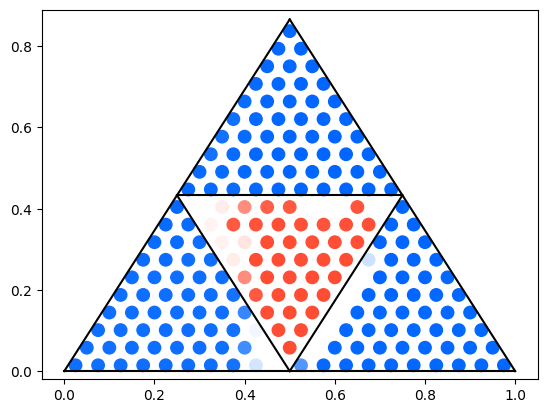

In [547]:
plt.scatter(value_single_shot_accuracy_list_phase_1_remap[:,0],value_single_shot_accuracy_list_phase_1_remap[:,1],c=value_single_shot_accuracy_list_phase_1_remap[:,2],s=80, cmap=cmap_blue)
plt.scatter(value_single_shot_accuracy_list_phase_2_remap[:,0],value_single_shot_accuracy_list_phase_2_remap[:,1],c=value_single_shot_accuracy_list_phase_2_remap[:,2],s=80, cmap=cmap_red)
#plt.colorbar()
plt.ylim([-.02,.89])

plt.plot(x_1,y_1,c='k')
plt.plot(x_2,y_2,c='k')
plt.plot(x_3,y_3,c='k')
plt.plot(x_left,y_left,c='k')
plt.plot(x_right,y_right,c='k')
plt.plot(x_bottom,y_bottom,c='k')

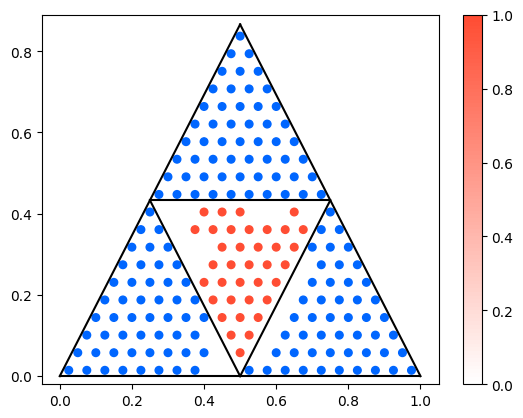

In [548]:
plt.scatter(max_choice_shot_accuracy_list_phase_1_remap[:,0],max_choice_shot_accuracy_list_phase_1_remap[:,1],c=max_choice_shot_accuracy_list_phase_1_remap[:,2],s=30, cmap=cmap_blue)
plt.scatter(max_choice_shot_accuracy_list_phase_2_remap[:,0],max_choice_shot_accuracy_list_phase_2_remap[:,1],c=max_choice_shot_accuracy_list_phase_2_remap[:,2],s=30, cmap=cmap_red)
plt.colorbar()
plt.ylim([-.02,.89])

plt.plot(x_1,y_1,c='k')
plt.plot(x_2,y_2,c='k')
plt.plot(x_3,y_3,c='k')
plt.plot(x_left,y_left,c='k')
plt.plot(x_right,y_right,c='k')
plt.plot(x_bottom,y_bottom,c='k')

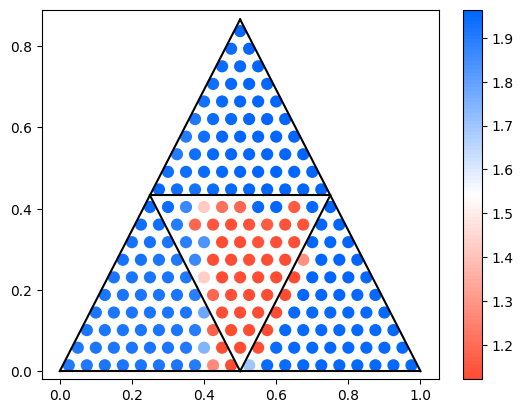

In [568]:
plt.scatter(y_pred_list_remap[:,0],y_pred_list_remap[:,1],c=y_pred_list_remap[:,2],s=60, cmap=cmap_red_blue)
plt.colorbar()
plt.ylim([-.02,.89])

plt.plot(x_1,y_1,c='k')
plt.plot(x_2,y_2,c='k')
plt.plot(x_3,y_3,c='k')
plt.plot(x_left,y_left,c='k')
plt.plot(x_right,y_right,c='k')
plt.plot(x_bottom,y_bottom,c='k')

plt.savefig('y_pred_phase_diag.pdf')

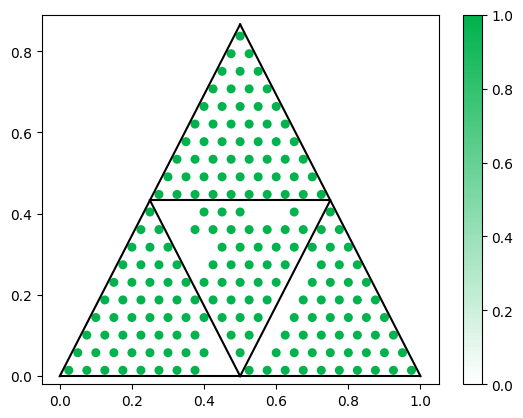

In [570]:
plt.scatter(correct_max_choice_list_remap[:,0],correct_max_choice_list_remap[:,1],c=correct_max_choice_list_remap[:,2],s=30, cmap=cmap_green)
plt.colorbar()
plt.ylim([-.02,.89])

plt.plot(x_1,y_1,c='k')
plt.plot(x_2,y_2,c='k')
plt.plot(x_3,y_3,c='k')
plt.plot(x_left,y_left,c='k')
plt.plot(x_right,y_right,c='k')
plt.plot(x_bottom,y_bottom,c='k')

plt.savefig('max_choice_accuracy_phase_diag.pdf')

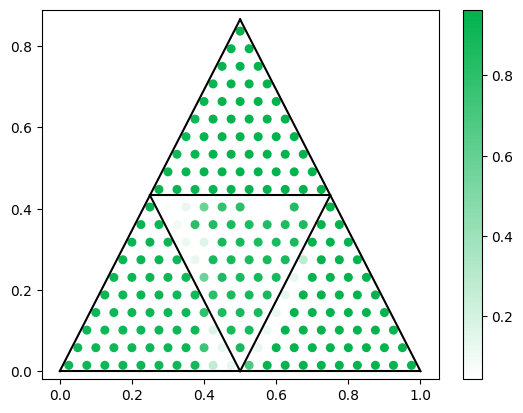

In [569]:
plt.scatter(value_single_shot_accuracy_list_remap[:,0],value_single_shot_accuracy_list_remap[:,1],c=value_single_shot_accuracy_list_remap[:,2],s=30, cmap=cmap_green)
plt.colorbar()
plt.ylim([-.02,.89])

plt.plot(x_1,y_1,c='k')
plt.plot(x_2,y_2,c='k')
plt.plot(x_3,y_3,c='k')
plt.plot(x_left,y_left,c='k')
plt.plot(x_right,y_right,c='k')
plt.plot(x_bottom,y_bottom,c='k')

plt.savefig('single_shot_accuracy_phase_diag.pdf')

visulisation of the points used to compute the test accuracy

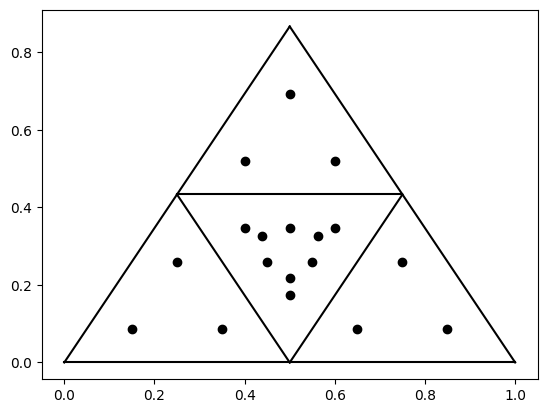

In [572]:
## evaluation set plot

from matplotlib import pyplot as plt
plt.plot(x_1,y_1,c='k')
plt.plot(x_2,y_2,c='k')
plt.plot(x_3,y_3,c='k')
plt.plot(x_left,y_left,c='k')
plt.plot(x_right,y_right,c='k')
plt.plot(x_bottom,y_bottom,c='k')

plt.scatter(test_scatter_map[:,0],test_scatter_map[:,1],c='k')

plt.savefig('evaluation_set.pdf')

In [ ]:
def phase_diagram_test_accuracy(phase_sensor,theta,resolution):
    value_single_shot_accuracy_mean = 0
    correct_max_choice_mean = 0
    value_single_shot_accuracy_list = np.array([])
    correct_max_choice_list = np.array([])
    NN = 0
    for Jx in np.arange(0,1+resolution,resolution):
        for Jy in np.arange(0,1-Jx+resolution,resolution):
            Jz = 1 - Jx - Jy
            x_test = np.array([Jx,Jy,Jz])
            if ((Jx >= Jy + Jz) or (Jy >= Jz + Jx) or (Jz >= Jx + Jy)):
                y_test = np.array([1,0])
            else:
                y_test = np.array([0,1])
            _,_,_,y_pred = qep.evaluate_phase_sensor(phase_sensor,x_test,theta)
            value_single_shot_accuracy = np.prod(y_test*y_pred + (1-y_test))
            value_single_shot_accuracy_mean += np.prod(y_test*y_pred + (1-y_test))
            value_single_shot_accuracy_list = np.append(value_single_shot_accuracy_list, [x_test[0], x_test[1], x_test[2], value_single_shot_accuracy])
            correct_max_choice = (np.argmax(y_test)==np.argmax(y_pred))
            correct_max_choice_mean += (np.argmax(y_test)==np.argmax(y_pred))
            correct_max_choice_list = np.append(correct_max_choice_list, [x_test[0], x_test[1], x_test[2], correct_max_choice])
            NN += 1
    return correct_max_choice_list, correct_max_choice_mean / NN, value_single_shot_accuracy_list, value_single_shot_accuracy_mean / NN

In [461]:
np.mean(correct_max_choice_list_remap[:,2])

0.9137931034482759

In [462]:
np.mean(value_single_shot_accuracy_list_remap[:,2])

0.8543096269723665

In [333]:
correct_max_choice

True

In [334]:
value_single_shot_accuracy

0.9209003472596403

at the end of the training with smaller learning rate (76 % single-shot accuracy)

In [353]:
correct_max_choice_list_2, correct_max_choice_mean_2, value_single_shot_accuracy_list_2, value_single_shot_accuracy_mean_2 = phase_diagram_test_accuracy(phase_sensor,results61['theta'][-1],.1)

In [355]:
correct_max_choice_list_2 = correct_max_choice_list_2.reshape((len(correct_max_choice_list_2)//4,4))
value_single_shot_accuracy_list_2 = value_single_shot_accuracy_list_2.reshape((len(value_single_shot_accuracy_list_2)//4,4))

In [356]:
np.savez("correct_max_choice_list_smallLearningRate.npz",correct_max_choice_list_2)
np.savez("value_single_shot_accuracy_list_smallLearningRate.npz",value_single_shot_accuracy_list_2)